In [1]:
import cv2
import numpy as np
import pandas as pd
import os
import glob
import json
import shutil
import sys
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

def find_project_root(marker=".gitignore"):
    current = Path.cwd()
    for parent in [current] + list(current.parents):
        if (parent / marker).exists():
            return parent.resolve()
    raise FileNotFoundError(
        f"Project root marker '{marker}' not found starting from {current}")
    
root = find_project_root()
src_path = f"{root}/src"
if src_path not in sys.path:
    sys.path.append(src_path)

### Run experiments

In [2]:
base_folder = f"{root}/images/STEREOS"
output_path = f"{root}/data/extrinsic_experiments.csv"
chessboard_size = (9, 6)
square_size_mm = 60

In [3]:
from calibrate_stereo_pair import calibrate_stereo_from_folder

experiments = [
    {'threshold': 0, 'win_size': (7, 7)},
    {'threshold': 0, 'win_size': (5, 5)},
    
    {'threshold': 0.4, 'win_size': (7, 7)},
    {'threshold': 0.4, 'win_size': (5, 5)},
    
    {'threshold': 0.2, 'win_size': (5, 5)},
    {'threshold': 0.1, 'win_size': (5, 5)},
    {'threshold': 0.09, 'win_size': (5, 5)}
]

intrinsic_path = os.path.join(root, "output", "V2_intrinsic_params.json")
with open(intrinsic_path, "r") as f:
    intrinsics = json.load(f)
    
results = []
for exp in experiments:
  stereo_a_folder = os.path.join(base_folder, "STEREO_A", "stereo_frames")
  stereo_a_params = calibrate_stereo_from_folder(
      cam_left_name="CAM_1",
      cam_right_name="CAM_2",
      folder=stereo_a_folder,
      chessboard_size=chessboard_size,
      square_size_mm=square_size_mm,
      intrinsic_left=intrinsics["CAM_1"],
      intrinsic_right=intrinsics["CAM_2"],
      error_threshold=exp["threshold"],
      window_size=exp["win_size"],
      allow_filtering=False if exp["threshold"] == 0 else True,
      debug_mode=False
  )

  stareo_a_results = {
    "stereo": "A",
    "threshold": exp["threshold"],
    "win_size": exp["win_size"][0],
    "frames_pairs_before": stereo_a_params["frame_pairs_before"],
    "frames_pairs_after": stereo_a_params["frame_pairs_after"],
    "error": stereo_a_params["reprojection_error"],
  }
  results.append(stareo_a_results)

  stereo_b_folder = os.path.join(base_folder, "STEREO_B", "stereo_frames")
  stereo_b_params = calibrate_stereo_from_folder(
      cam_left_name="CAM_3",
      cam_right_name="CAM_4",
      folder=stereo_b_folder,
      chessboard_size=chessboard_size,
      square_size_mm=square_size_mm,
      intrinsic_left=intrinsics["CAM_3"],
      intrinsic_right=intrinsics["CAM_4"],
      error_threshold=exp["threshold"],
      window_size=exp["win_size"],
      allow_filtering=False if exp["threshold"] == 0 else True,
      debug_mode=False
  )

  stareo_a_results = {
    "stereo": "B",
    "threshold": exp["threshold"],
    "win_size": exp["win_size"][0],
    "frames_pairs_before": stereo_b_params["frame_pairs_before"],
    "frames_pairs_after": stereo_b_params["frame_pairs_after"],
    "error": stereo_b_params["reprojection_error"],
  }
  results.append(stareo_a_results)



results_df = pd.DataFrame(results)
results_df.to_csv(output_path, index=False)


Processing folders:   0%|          | 0/24 [00:03<?, ?it/s]


KeyboardInterrupt: 

### Load df

In [2]:
original_df = pd.read_csv(f"{root}/data/extrinsic_experiments.csv")
stereo_a_color = '#1F4E79'
stereo_b_color = '#2D7D46'

### Bar plots

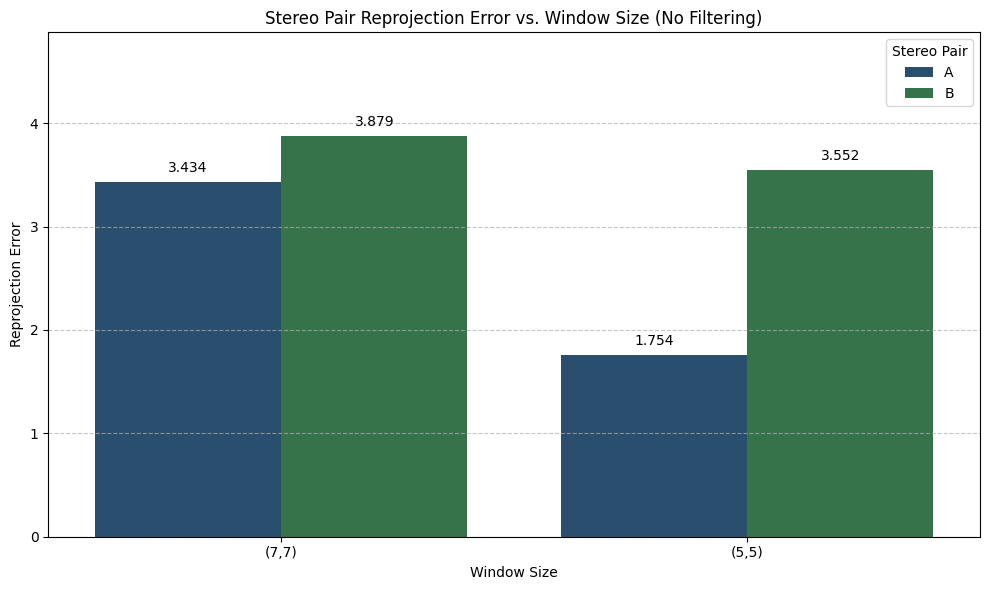

In [31]:
import seaborn as sns

# Filter the data for threshold 0
df_threshold_0 = original_df[original_df['threshold'] == 0]

# Sort the data by reprojection error in descending order
df_threshold_0 = df_threshold_0.sort_values(by='error', ascending=False)

# Plot Reprojection Error vs. Window Size for Threshold 0
plt.figure(figsize=(10, 6))
stereo_order = ['A', 'B']  # Order of stereo pairs

barplot = sns.barplot(x='win_size', y='error', hue='stereo', data=df_threshold_0,
                      palette=[stereo_a_color, stereo_b_color],
                      order=[7, 5],
                      hue_order=stereo_order)
plt.title('Stereo Pair Reprojection Error vs. Window Size (No Filtering)')
plt.xlabel('Window Size')
plt.ylabel('Reprojection Error')
plt.legend(title='Stereo Pair', loc='upper right')
plt.ylim(0, df_threshold_0['error'].max() + 1)
plt.xticks(ticks=[0, 1], labels=["(7,7)", "(5,5)"])
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate bars with exact values
for p in barplot.patches:
    height = p.get_height()
    if height > 0:
        barplot.annotate(f'{height:.3f}',
                         (p.get_x() + p.get_width() / 2., height),
                         ha='center', va='bottom',
                         xytext=(0, 5),
                         textcoords='offset points')

plt.tight_layout()
plt.show()

### Reprojection error vs filtering threshold

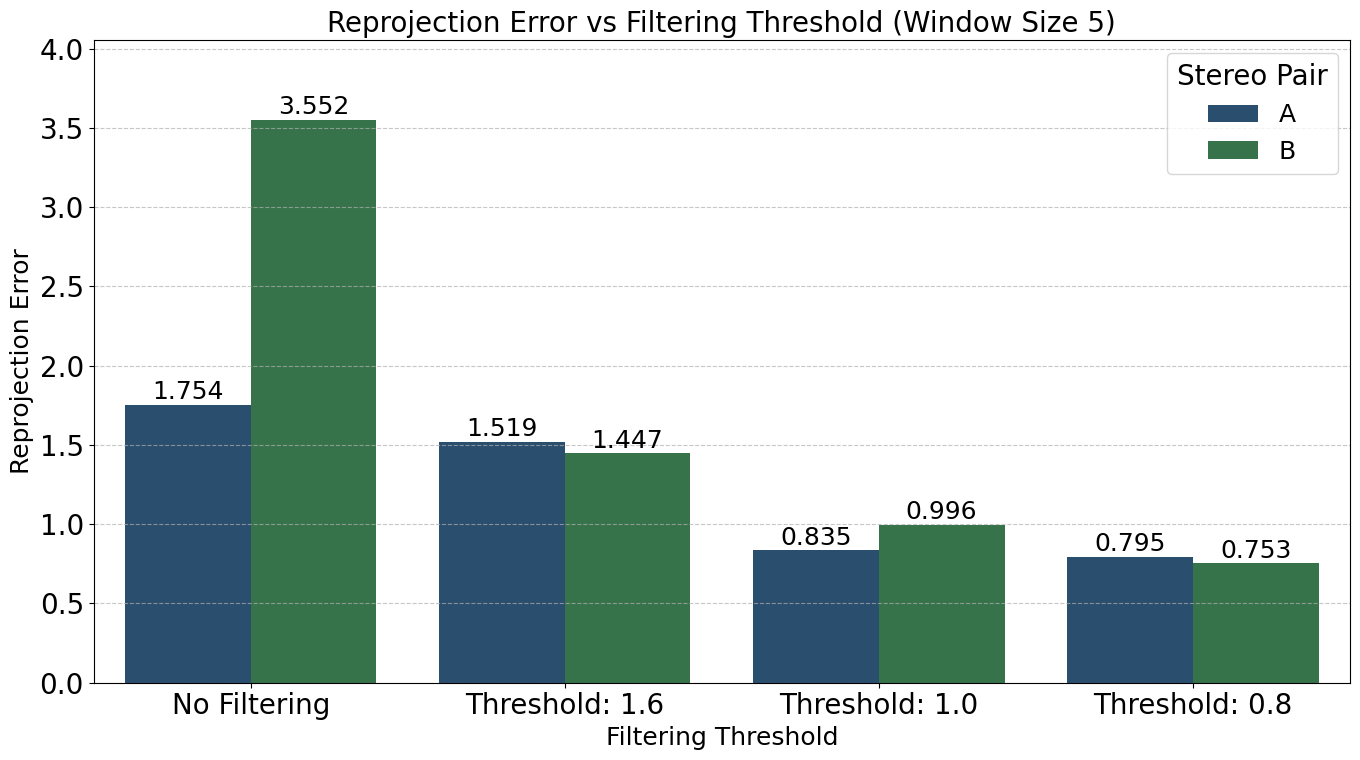

In [4]:
df = original_df[original_df['win_size'] != 7]
df = df[df['threshold'] != 0.4]

# Update the reprojection error for stereo B when threshold is 0.09
df.loc[(df['threshold'] == 0.09) & (df['stereo'] == 'B'), 'error'] = 0.753

# Create threshold label mapping
def get_threshold_label(row):
    threshold = row['threshold']
    if threshold == 0:
        return "No Filtering"
    elif threshold == 0.2:
        return "Threshold: 1.6"
    elif threshold == 0.1:
        return "Threshold: 1.0"
    elif threshold == 0.09:
        return "Threshold: 0.8"
    else:
        return f"Threshold: {threshold}"

# Apply the mapping to create experiment labels
df['experiment'] = df.apply(get_threshold_label, axis=1)

# Sort the data by reprojection error in descending order
df = df.sort_values(by='error', ascending=False)

# Plot Reprojection Error for Each Experiment
plt.figure(figsize=(14, 8))
camera_order = ['A', 'B']
plt.rcParams.update({'font.size': 20})
barplot = sns.barplot(x='experiment', y='error', hue='stereo', data=df, palette=[
                      stereo_a_color, stereo_b_color], hue_order=camera_order)

plt.title('Reprojection Error vs Filtering Threshold (Window Size 5)', fontsize=20)
plt.xlabel('Filtering Threshold', fontsize=18)
plt.ylabel('Reprojection Error', fontsize=18)
plt.legend(title='Stereo Pair', loc='upper right', fontsize=18)
plt.ylim(0, df['error'].max() + 0.5)  # Adjust y-axis limit for better readability
plt.xticks(rotation=0, ha='center')  # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add grid for better readability

# Annotate the bars with the exact reprojection error values
for p in barplot.patches:
    height = p.get_height()
    if height > 0:  # Skip annotation for zero values
        barplot.annotate(format(height, '.3f'),
                         (p.get_x() + p.get_width() / 2., height),
                         ha='center', va='center',
                         xytext=(0, 9),
                         textcoords='offset points',
                         fontsize=18)

plt.tight_layout()
plt.show()

/var/folders/8z/9lk7_58n1dzgvd97cfqznmxc0000gn/T/ipykernel_4670/4291684224.py:20: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  barplot = sns.barplot(x='stereo', y='frame_pairs', hue='threshold_label', data=df_combined,


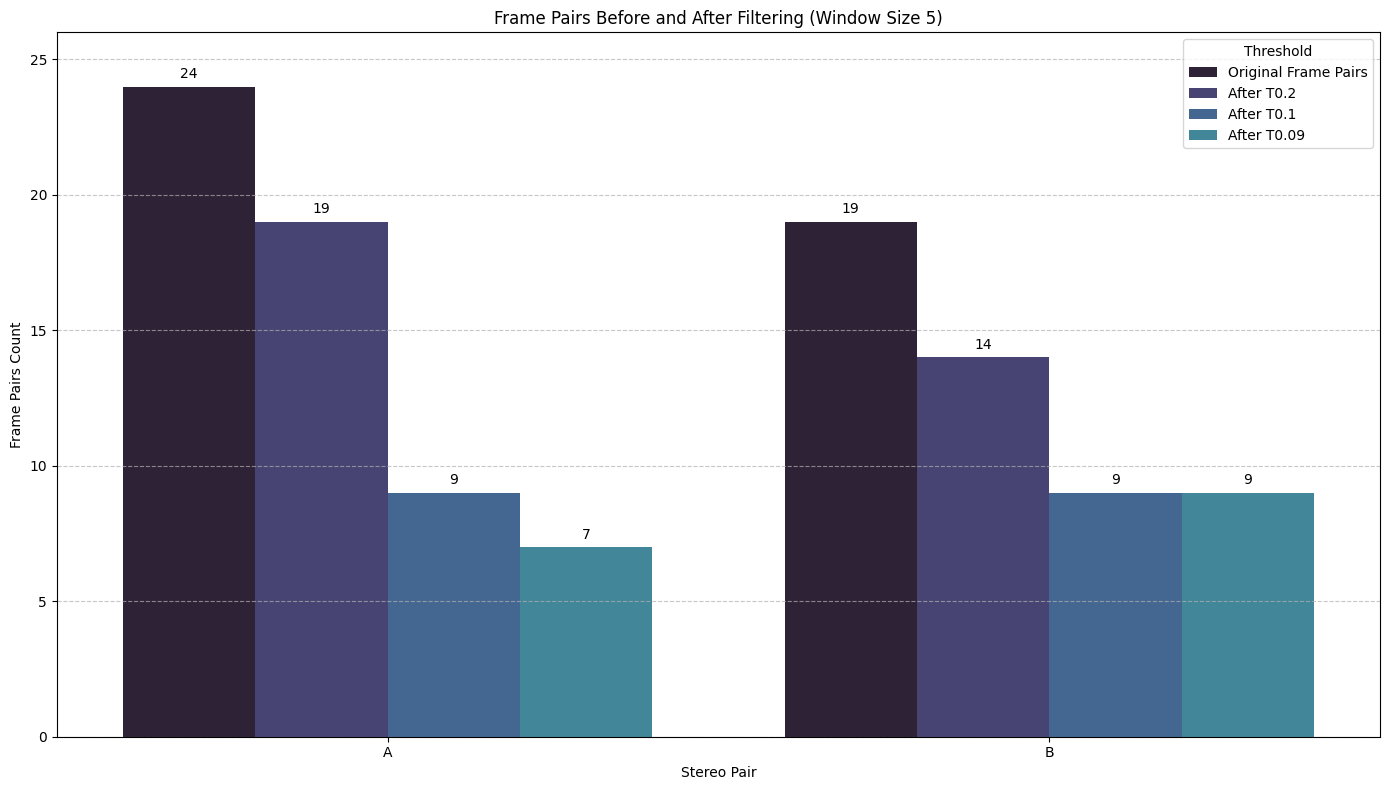

In [32]:
df = original_df[original_df['win_size'] == 5]
df = df[df['threshold'] != 0.4]

# Get frames_pairs_after (excluding threshold 0)
df_after = df[df['threshold'] != 0][['stereo', 'threshold', 'frames_pairs_after']].copy()
df_after['threshold_label'] = df_after['threshold'].apply(lambda x: f'After T{x}')
df_after = df_after.rename(columns={'frames_pairs_after': 'frame_pairs'})

# Add ONE single frames_pairs_before entry for each stereo pair
df_before = df[['stereo', 'frames_pairs_before']].drop_duplicates().copy()
df_before['threshold_label'] = 'Original Frame Pairs'
df_before = df_before.rename(columns={'frames_pairs_before': 'frame_pairs'})

# Combine and plot
df_combined = pd.concat([df_before, df_after])
threshold_order = ['Original Frame Pairs'] + [f'After T{x}' for x in sorted(df_after['threshold'].unique(), reverse=True)]
stereo_order = ['A', 'B']
plt.figure(figsize=(14, 8))

barplot = sns.barplot(x='stereo', y='frame_pairs', hue='threshold_label', data=df_combined, 
                     palette=sns.color_palette("mako"), errorbar=None, 
                     order=stereo_order, hue_order=threshold_order)

plt.title('Frame Pairs Before and After Filtering (Window Size 5)')
plt.xlabel('Stereo Pair')
plt.ylabel('Frame Pairs Count')
plt.legend(title='Threshold', loc='upper right')
plt.ylim(0, df_combined['frame_pairs'].max() + 2)  # Adjust y-axis limit for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add grid for better readability

# Annotate the bars with the exact frame pair counts
for p in barplot.patches:
    height = p.get_height()
    if height > 0:
        barplot.annotate(format(height, '.0f'),
                         (p.get_x() + p.get_width() / 2., height),
                         ha='center', va='center',
                         xytext=(0, 9),
                         textcoords='offset points')

plt.tight_layout()
plt.show()

/var/folders/8z/9lk7_58n1dzgvd97cfqznmxc0000gn/T/ipykernel_68762/3673221730.py:37: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  barplot = sns.barplot(x='stereo', y='frame_pairs', hue='threshold_label', data=df_combined,


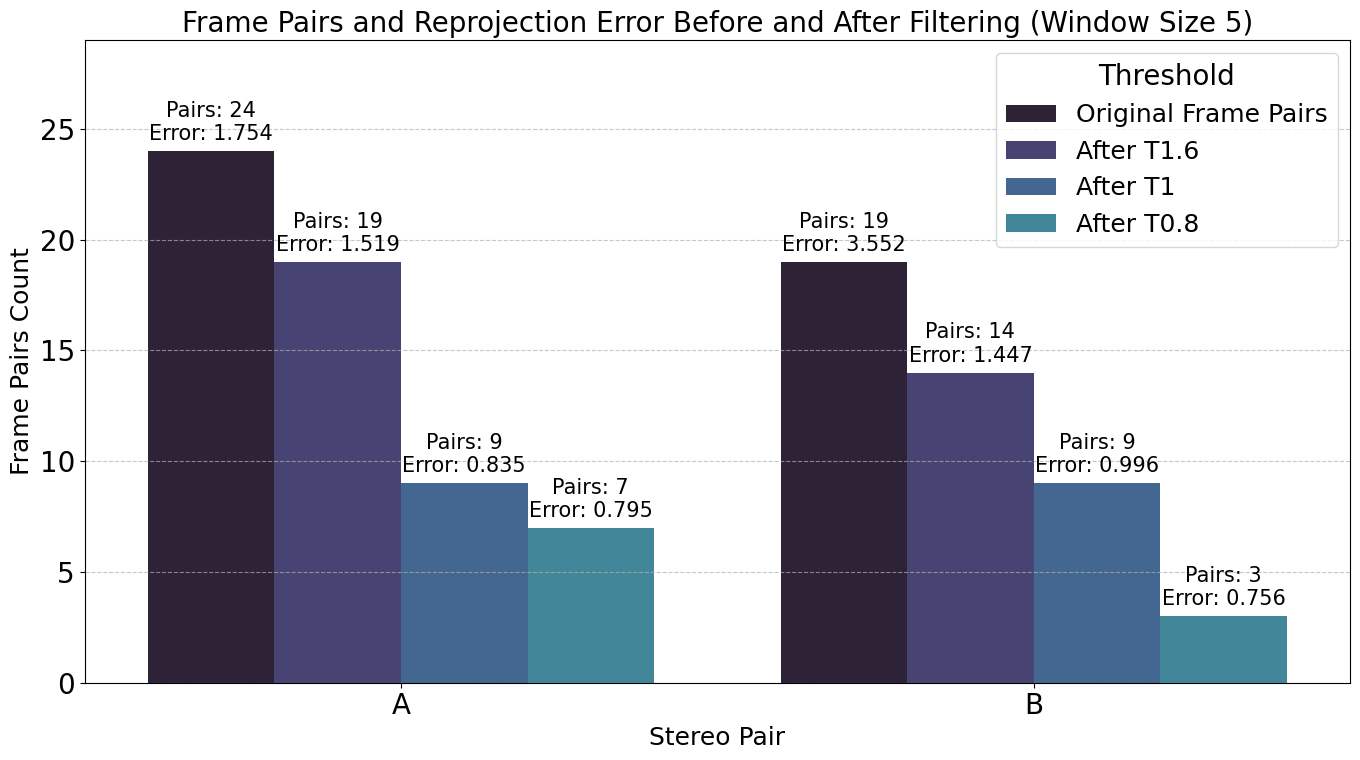

In [7]:
df = original_df[original_df['win_size'] == 5]
df = df[df['threshold'] != 0.4]

# Define threshold label mapping
def get_threshold_label(threshold):
    if threshold == 0:
        return "No Filtering"
    elif threshold == 0.2:
        return "After T1.6"
    elif threshold == 0.1:
        return "After T1"
    elif threshold == 0.09:
        return "After T0.8"
    else:
        return f"After T{threshold}"

df_after = df[df['threshold'] != 0][['stereo', 'threshold', 'frames_pairs_after', 'error']].copy()
df_after['threshold_label'] = df_after['threshold'].apply(get_threshold_label)
df_after = df_after.rename(columns={'frames_pairs_after': 'frame_pairs'})

# Add ONE single frames_pairs_before entry for each stereo pair
df_before = df[['stereo', 'frames_pairs_before', 'error']].drop_duplicates().copy()
df_before['threshold_label'] = 'Original Frame Pairs'
df_before = df_before.rename(columns={'frames_pairs_before': 'frame_pairs'})

# Combine and plot
df_combined = pd.concat([df_before, df_after]).sort_values(['stereo', 'threshold_label'])

# Create threshold order with the new labels
threshold_values = sorted(df_after['threshold'].unique(), reverse=True)
threshold_order = ['Original Frame Pairs'] + [get_threshold_label(x) for x in threshold_values]

stereo_order = ['A', 'B']
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(14, 8))

barplot = sns.barplot(x='stereo', y='frame_pairs', hue='threshold_label', data=df_combined, 
                     palette=sns.color_palette("mako"), errorbar=None, 
                     order=stereo_order, hue_order=threshold_order)

plt.title('Frame Pairs and Reprojection Error Before and After Filtering (Window Size 5)', fontsize=20)
plt.xlabel('Stereo Pair', fontsize=18)
plt.ylabel('Frame Pairs Count', fontsize=18)
plt.legend(title='Threshold', loc='upper right', fontsize=18)
plt.ylim(0, df_combined['frame_pairs'].max() + 5)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Calculate number of bars per stereo pair
n_thresholds = len(threshold_order)

for idx, p in enumerate(barplot.patches):
    height = p.get_height()
    if height > 0:
        # Calculate which stereo and threshold this bar represents
        stereo_idx = idx % len(stereo_order)
        threshold_idx = idx // len(stereo_order)
        
        stereo = stereo_order[stereo_idx]
        threshold_label = threshold_order[threshold_idx]
        
        # Get the corresponding data
        row = df_combined[(df_combined['stereo'] == stereo) & 
                         (df_combined['threshold_label'] == threshold_label)]
        
        if not row.empty:
            # Create annotation text with both values
            annotation = f'Pairs: {int(height)}\nError: {row["error"].iloc[0]:.3f}'
            
            barplot.annotate(annotation,
                            (p.get_x() + p.get_width() / 2, height),
                            ha='center', va='bottom',
                            xytext=(0, 5),
                            textcoords='offset points',
                            fontsize=15)

plt.tight_layout()
plt.show()

### Table

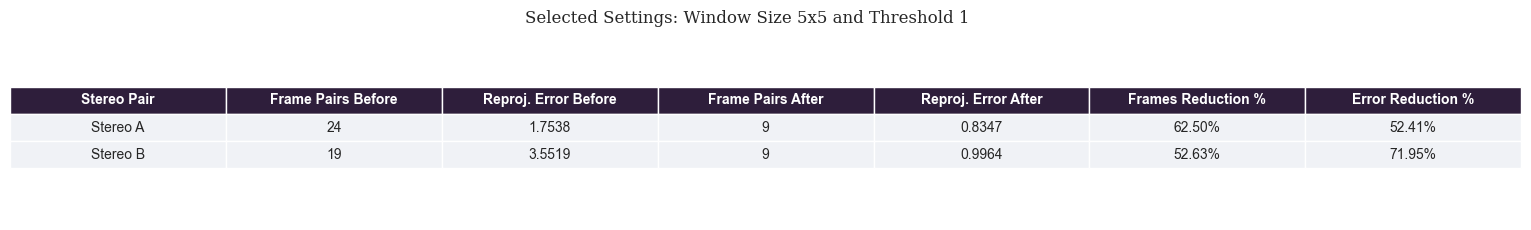

In [11]:
# Get baseline reprojection errors (threshold = 0, win_size = 5)
baseline_df = original_df[
    (original_df['win_size'] == 5) & 
    (original_df['threshold'] == 0)
].set_index('stereo')['error'].to_dict()

# Filter for the selected experiment
df_selected = original_df[(original_df['win_size'] == 5) & (original_df['threshold'] == 0.1)].copy()

# Define column configuration
column_config = {
    'stereo': {
        'label': 'Stereo Pair',
        'format': lambda row: f"Stereo {row['stereo']}"
    },
    'frames_pairs_before': {
        'label': 'Frame Pairs Before',
        'format': lambda row: int(row['frames_pairs_before'])
    },
    'error_before': {
        'label': 'Reproj. Error Before',
        'format': lambda row: f"{baseline_df[row['stereo']]:.4f}"
    },
    'frames_pairs_after': {
        'label': 'Frame Pairs After',
        'format': lambda row: int(row['frames_pairs_after'])
    },
    'error_after': {
        'label': 'Reproj. Error After',
        'format': lambda row: f"{row['error']:.4f}"
    },
    'frames_reduction': {
        'label': 'Frames Reduction %',
        'format': lambda row: f"{((row['frames_pairs_before'] - row['frames_pairs_after']) / row['frames_pairs_before']) * 100:.2f}%"
    },
    'error_reduction': {
        'label': 'Error Reduction %',
        'format': lambda row: f"{((baseline_df[row['stereo']] - row['error']) / baseline_df[row['stereo']]) * 100:.2f}%"
    }
}

# Create table data
table_data = []
for index, row in df_selected.iterrows():
    row_data = [column_config[col]['format'](row) for col in column_config.keys()]
    table_data.append(row_data)

# Get column labels in the same order
column_labels = [column_config[col]['label'] for col in column_config.keys()]

sns.set_style("whitegrid")
sns.set_palette("deep")
fig, ax = plt.subplots(figsize=(15, 2.5))
ax.axis('tight')
ax.axis('off')

# Create the table
table = ax.table(cellText=table_data,
                colLabels=column_labels,
                cellLoc='center',
                loc='center',
                colColours=[sns.color_palette("mako")[0]]*len(column_labels))

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.3, 1.7)

# Style the cells
for cell in table._cells:
    table._cells[cell].set_edgecolor('#FFFFFF')
    if cell[0] == 0:  # Header row
        table._cells[cell].set_text_props(color='white', weight='bold')
        table._cells[cell].set_facecolor(sns.color_palette("mako")[0])
    else:  # Data rows
        table._cells[cell].set_text_props(wrap=True)
        table._cells[cell].set_facecolor('#F0F2F6')

plt.suptitle('Selected Settings: Window Size 5x5 and Threshold 1', 
             y=0.95,
             fontsize=12,
             fontweight='medium',
             fontfamily='serif')

plt.subplots_adjust(top=0.85)
plt.show()